# Price stock tendency prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import mlflow
import mlflow.sklearn
from tqdm.notebook import trange, tqdm

from DataHelper import *


# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
DATA_PATH = './data'
QUOTATION = 'AMZN'
FILE_SUFFIX = '.txt'

In [3]:
df = get_data(DATA_PATH, f"{QUOTATION}{FILE_SUFFIX}")
df.head()

,Date,Open,High,Low,Close,Volume,Adjusted
1,2007-01-03,38.680000,39.060001,38.049999,38.700001,12405100,38.700001
2,2007-01-04,38.590000,39.139999,38.259998,38.900002,6318400,38.900002
3,2007-01-05,38.720001,38.790001,37.599998,38.369999,6619700,38.369999
4,2007-01-08,38.220001,38.310001,37.169998,37.500000,6783000,37.500000
5,2007-01-09,37.599998,38.060001,37.340000,37.779999,5703000,37.779999


In [4]:
price_column = 'Close'
keep_columns = ['Date', price_column, 'Volume']

In [5]:
df = df.loc[:, keep_columns]

print(len(df))
df.head()

3525


,Date,Close,Volume
1,2007-01-03,38.700001,12405100
2,2007-01-04,38.900002,6318400
3,2007-01-05,38.369999,6619700
4,2007-01-08,37.500000,6783000
5,2007-01-09,37.779999,5703000


In [6]:
df.isna().any()

Date      False
Close     False
Volume    False
dtype: bool

### Plots

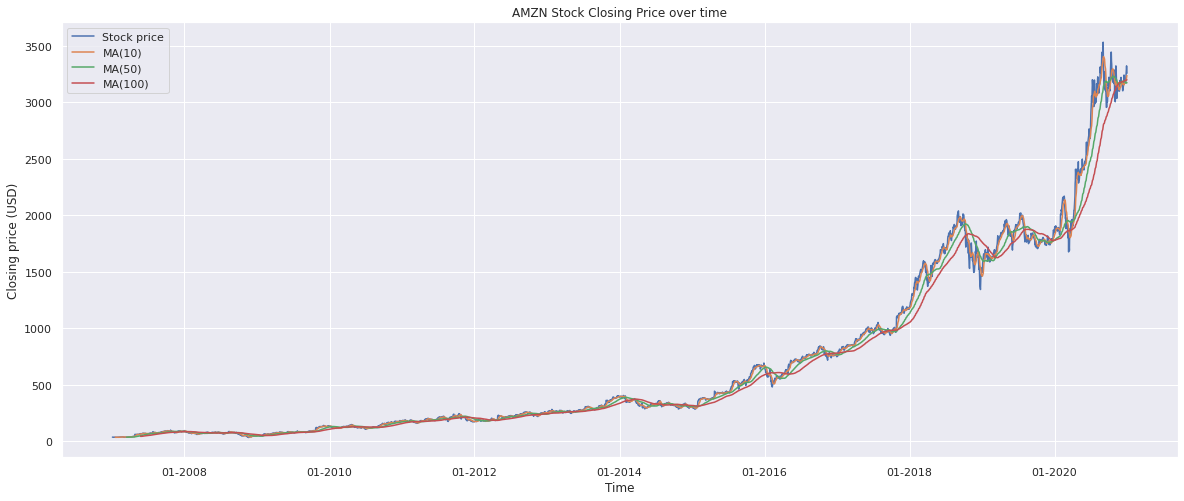

In [7]:
import datetime
import matplotlib.dates as mdates

N_YEARS = 50
values = df.tail(365*N_YEARS)[price_column]

x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in df.tail(365*N_YEARS).Date]
ax = plt.gca()
ax.set(title=f"{QUOTATION} Stock Closing Price over time", ylabel='Closing price (USD)', xlabel='Time')

formatter = mdates.DateFormatter("%m-%Y")

ax.xaxis.set_major_formatter(formatter)

MAs = [10, 50, 100]

plt.plot(x_values, values, label="Stock price")

for val in MAs:
    plt.plot(x_values, values.rolling(val).mean(), label=f"MA({val})")

plt.legend(loc='best')

### Preprocessing, compute some indicators

In [8]:
df['Difference'] = compute_column_difference(df, column=price_column)
df['PercentageDiff'] = compute_percentage_diff(df)

### Plot histogram differences

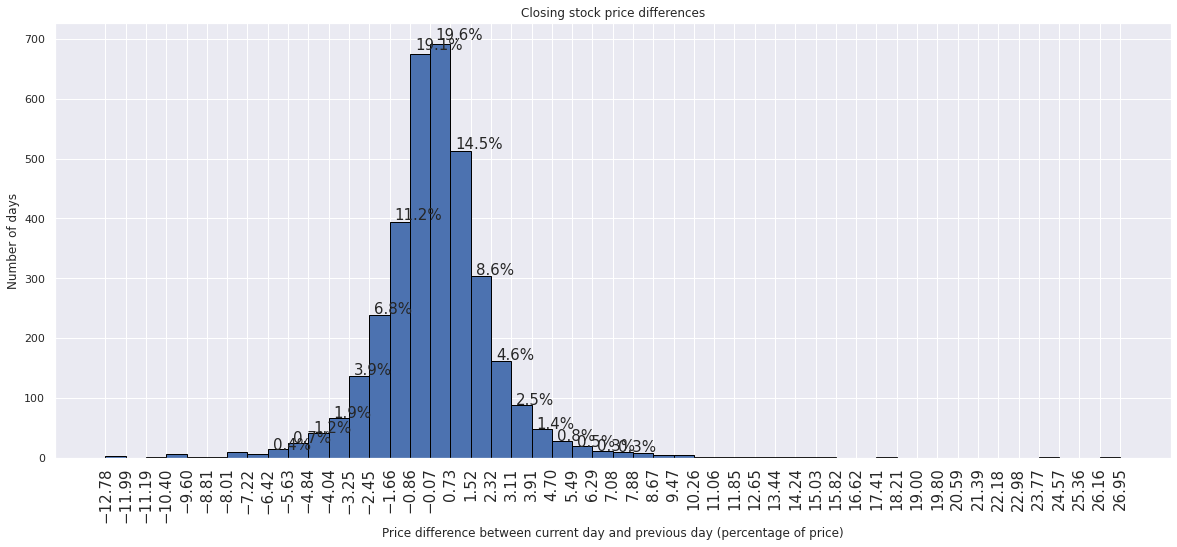

In [9]:
import matplotlib.ticker as mtick

def label_density_hist(ax, n, bins, x=4, y=0.01, r=0, **kwargs):
    """
    adapted from https://stackoverflow.com/questions/6352740/matplotlib-label-each-bin
    """
    
    total = sum(n)

    # plot the label/text to each bin
    for i in range(0, len(n)):
        x_pos = (bins[i + 1] - bins[i]) / x + bins[i]
        y_pos = n[i] + (n[i] * y)
        
        if n[i] < 10:
            continue
        
        label = f"{(n[i] * 100.0 / total):.1f}%"
        ax.text(x_pos, y_pos, label, kwargs)
        
values = df['PercentageDiff']
ax = plt.gca()

counts, bins, patches = ax.hist(values, 50, histtype='bar', ec='black')
plt.xticks(bins, fontsize=15, rotation=90)
plt.title("Closing stock price differences")
plt.xlabel('Price difference between current day and previous day (percentage of price)')
plt.ylabel('Number of days')
label_density_hist(ax, counts, bins, fontsize=15)
plt.show()

### Compute the price tendency (IE going up or down since yesterday)

In [10]:
df['Tendency'] = compute_tendency_percentage(df, diff_column='Difference', labels=['lower','higher'])
value_counts = df.Tendency.value_counts().to_dict()

for value, count in value_counts.items():
    print(f"[{value}] : {count} ({count * 100.0 / len(df['Tendency']):.1f}%)")
    
df.head(50)

[higher] : 1844 (52.3%)
[lower] : 1681 (47.7%)


,Date,Close,Volume,Difference,PercentageDiff,Tendency
1,2007-01-03,38.700001,12405100,0.000000,0.000000,lower
2,2007-01-04,38.900002,6318400,0.200001,0.516798,higher
3,2007-01-05,38.369999,6619700,-0.530003,-1.362476,lower
4,2007-01-08,37.500000,6783000,-0.869999,-2.267394,lower
5,2007-01-09,37.779999,5703000,0.279999,0.746664,higher
6,2007-01-10,37.150002,6527500,-0.629997,-1.667541,lower
7,2007-01-11,37.400002,6465600,0.250000,0.672947,higher
8,2007-01-12,38.200001,4466400,0.799999,2.139035,higher
9,2007-01-16,38.660000,5643700,0.459999,1.204186,higher
10,2007-01-17,37.880001,5026800,-0.779999,-2.017587,lower


### Add the rolling average

In [11]:
N=10

ma_name = f"MA({N})"

df[ma_name] = df[price_column].rolling(N).mean()

print(df.head(15))

          Date      Close    Volume  Difference  PercentageDiff Tendency  \
1   2007-01-03  38.700001  12405100    0.000000        0.000000    lower   
2   2007-01-04  38.900002   6318400    0.200001        0.516798   higher   
3   2007-01-05  38.369999   6619700   -0.530003       -1.362476    lower   
4   2007-01-08  37.500000   6783000   -0.869999       -2.267394    lower   
5   2007-01-09  37.779999   5703000    0.279999        0.746664   higher   
6   2007-01-10  37.150002   6527500   -0.629997       -1.667541    lower   
7   2007-01-11  37.400002   6465600    0.250000        0.672947   higher   
8   2007-01-12  38.200001   4466400    0.799999        2.139035   higher   
9   2007-01-16  38.660000   5643700    0.459999        1.204186   higher   
10  2007-01-17  37.880001   5026800   -0.779999       -2.017587    lower   
11  2007-01-18  36.980000   9105000   -0.900001       -2.375927    lower   
12  2007-01-19  37.020000   6095900    0.040000        0.108167   higher   
13  2007-01-

### Add rolling average difference 

In [12]:
N_a = 20
N_b = 10

df[f"MA_diff"] = df[price_column].rolling(N_a).mean() - df[price_column].rolling(N_b).mean()

### Add the RSI

In [13]:
N = 14
rsi_name = f"RSI({N})"
df[rsi_name] = compute_RSI(df, 14, price_column=price_column, diff_column='Difference')

df[f"RSI_diff"] = compute_column_difference(df, column=rsi_name)

### Volume difference 

In [14]:
df['Volume_diff'] = compute_column_difference(df, column='Volume')

### Shift the tendencies to predict next day

In [15]:
def shift_values(df, column):
    shifted_column = df[column]
    shifted_column = shifted_column.shift(periods=-1)    
    return shifted_column
     
df['Next'] = shift_values(df, 'Tendency')
df.head()

,Date,Close,Volume,Difference,PercentageDiff,Tendency,MA(10),MA_diff,RSI(14),RSI_diff,Volume_diff,Next
1,2007-01-03,38.700001,12405100,0.000000,0.000000,lower,NaN,NaN,NaN,0.0,0,higher
2,2007-01-04,38.900002,6318400,0.200001,0.516798,higher,NaN,NaN,NaN,NaN,-6086700,lower
3,2007-01-05,38.369999,6619700,-0.530003,-1.362476,lower,NaN,NaN,NaN,NaN,301300,lower
4,2007-01-08,37.500000,6783000,-0.869999,-2.267394,lower,NaN,NaN,NaN,NaN,163300,higher
5,2007-01-09,37.779999,5703000,0.279999,0.746664,higher,NaN,NaN,NaN,NaN,-1080000,lower


### Remove nulls introduced by previous operations

In [16]:
df = df.dropna()

### ML Data preparation

In [17]:
df.head()

,Date,Close,Volume,Difference,PercentageDiff,Tendency,MA(10),MA_diff,RSI(14),RSI_diff,Volume_diff,Next
20,2007-01-31,37.669998,7277500,0.619999,1.673412,higher,37.072,0.491001,53.915634,9.404359,2464000,higher
21,2007-02-01,38.700001,26123100,1.030003,2.734279,higher,37.244,0.319000,58.760100,4.844466,18845600,lower
22,2007-02-02,37.389999,25850700,-1.310002,-3.385018,lower,37.281,0.206500,44.892802,-13.867298,-272400,lower
23,2007-02-05,37.160000,6110900,-0.229999,-0.615135,lower,37.302,0.125001,40.259745,-4.633057,-19739800,higher
24,2007-02-06,38.270000,8612700,1.110000,2.987083,higher,37.486,-0.020499,52.428386,12.168640,2501800,higher


In [18]:
data_columns = ['Close', 'PercentageDiff', 'Volume_diff', rsi_name, 'RSI_diff', 'Next', 'Volume','MA_diff', ma_name]

dataset = df.copy()

dataset = df.loc[:, data_columns]
#df = df.drop(columns=['Tendency', 'Date', 'Difference'])

dataset.head()

,Close,PercentageDiff,Volume_diff,RSI(14),RSI_diff,Next,Volume,MA_diff,MA(10)
20,37.669998,1.673412,2464000,53.915634,9.404359,higher,7277500,0.491001,37.072
21,38.700001,2.734279,18845600,58.760100,4.844466,lower,26123100,0.319000,37.244
22,37.389999,-3.385018,-272400,44.892802,-13.867298,lower,25850700,0.206500,37.281
23,37.160000,-0.615135,-19739800,40.259745,-4.633057,higher,6110900,0.125001,37.302
24,38.270000,2.987083,2501800,52.428386,12.168640,higher,8612700,-0.020499,37.486


### Dataset class balance

<AxesSubplot:>

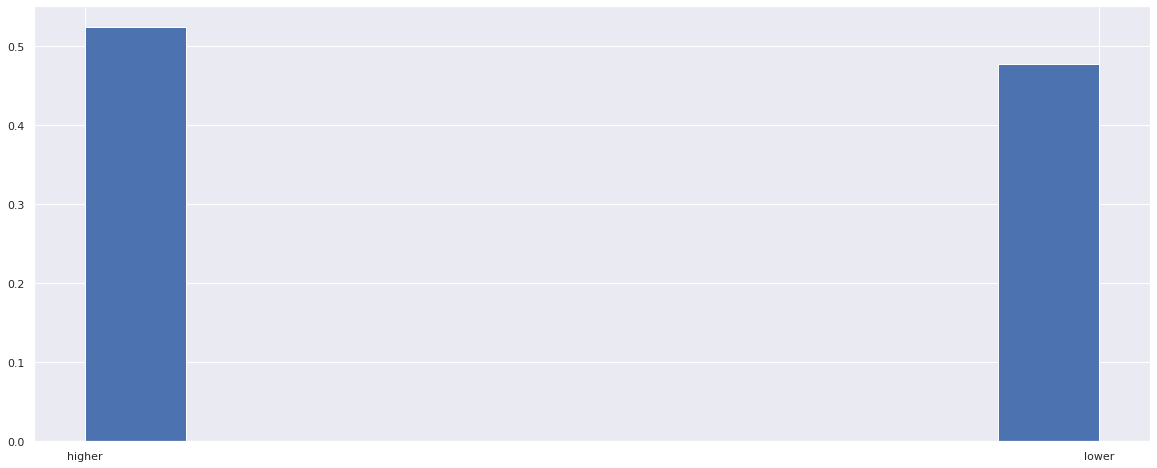

In [19]:
# plot normalized histogram
dataset['Next'].hist(weights = np.ones_like(dataset.Next) / len(dataset.Next))

### Train / Test data 

In [20]:
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']

In [21]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO = 0.7

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=TRAIN_RATIO, random_state=42)

print(f"Train size : {len(X_train)}, test size : {len(X_test)} ({(1-TRAIN_RATIO)*100:.0f}%)")

Train size : 2453, test size : 1052 (30%)


## Classifier and evaluation

In [22]:
from sklearn.utils.class_weight import compute_class_weight

USE_CLASS_WEIGHTS = False

if USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight('balanced', np.unique(Y), Y)
    # format as dict
    class_weights = {c:w for c,w in zip(np.unique(Y), class_weights)}

    print(class_weights)
else:
    class_weights = None

### Grid Search

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

PERFORM_GRID_SEARCH = False

# default parameters
best_params = {'DTree': {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}, 
               'RandomForest': {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 200}, 
               'SVM': {'gamma': 'auto'}, 'LR': {'penalty': 'l2', 'C': 1.0}
              }

param_grid = {
    'DTree':{
        'criterion':('entropy', 'gini'),
        'max_depth':[1,2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
    },
    'RandomForest':{
        'criterion':('entropy', 'gini'),
        'n_estimators':[50,100,200,500],
        'max_depth':[2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
        'max_features':['auto', 'sqrt', 'log2'], 
    },
    'SVM':{
        'C':[1.0],
        'kernel':('linear', 'poly', 'rbf'),
        'gamma':('scale', 'auto'),
    },
    'LR':
    {
        'penalty':('none', 'l2'),
        'C':[0.5, 1.0]
    },   
    
}

if PERFORM_GRID_SEARCH:
    print("Performing grid search...")
    dtree = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(dtree, param_grid['DTree'], n_jobs=4)

    
    clf.fit(X_train, Y_train)
    best_params['DTree'] = clf.best_params_

    random_forest = RandomForestClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(random_forest, param_grid['RandomForest'], n_jobs=8)
    clf.fit(X_train, Y_train)
    best_params['RandomForest'] = clf.best_params_

    
    """svm = SVC(random_state=42, class_weight=class_weights, cache_size=4096)
    clf = GridSearchCV(svm, param_grid['SVM'], n_jobs=4, verbose=30)
    clf.fit(X_train, Y_train)
    best_params['SVM'] = clf.best_params_"""
    
    lr = LogisticRegression(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(lr, param_grid['LR'], n_jobs=4)
    clf.fit(X_train, Y_train)


    print(best_params)

### Classifiers

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

clf_dict = {}

clf_dict['DTree'] = DecisionTreeClassifier(**best_params['DTree'], random_state=42, class_weight=class_weights)
clf_dict['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=42, class_weight=class_weights)
clf_dict['SVM'] = SVC(**best_params['SVM'], class_weight=class_weights)
clf_dict['LR'] = LogisticRegression(**best_params['LR'], class_weight=class_weights)

### Training

In [25]:
print("Training...")

for clf_label, clf in clf_dict.items():
    clf.fit(X_train, Y_train)
    
print("Training done.")

Training...
Training done.


[DTree] Accuracy : 0.50, F1 : 0.50
[RandomForest] Accuracy : 0.52, F1 : 0.53
[SVM] Accuracy : 0.53, F1 : 0.70
[LR] Accuracy : 0.54, F1 : 0.54


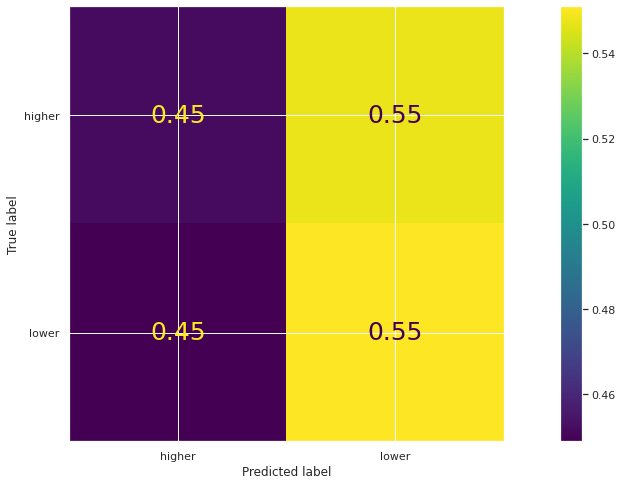

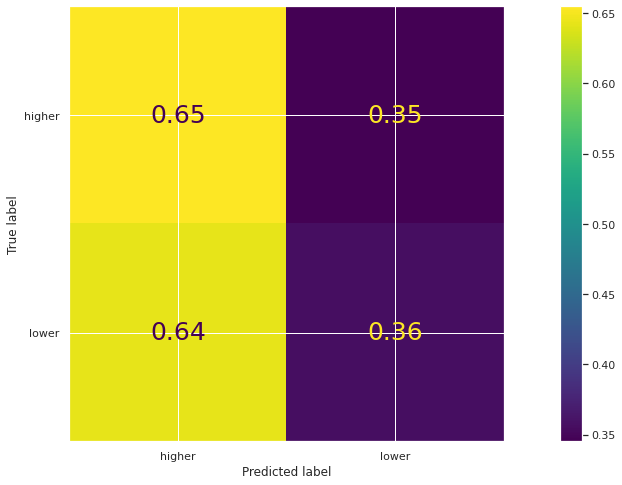

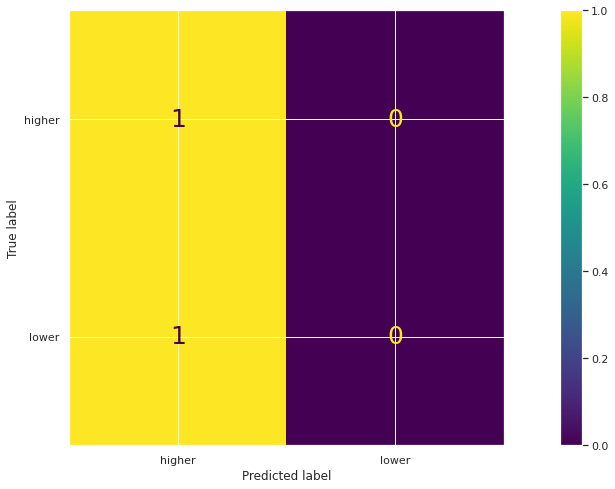

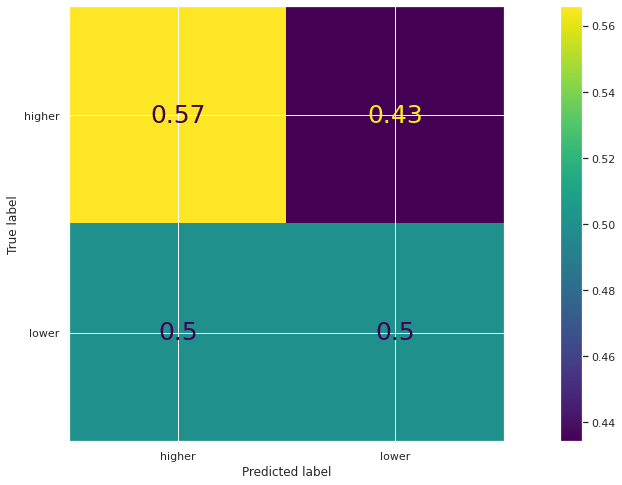

In [26]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

for clf_label, clf in clf_dict.items():
    with mlflow.start_run(run_name=clf_label):
        Y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(Y_pred, Y_test)
        f1 = f1_score(Y_pred, Y_test, average='weighted')
        


        for param, val in best_params[clf_label].items():
            mlflow.log_param(param, val)
        mlflow.log_metric('acc', accuracy)
        mlflow.log_metric('f1', f1)
        mlflow.sklearn.log_model(clf, "sklearn model")
    
    print(f"[{clf_label}] Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")
    plot_confusion_matrix(clf, X_test, Y_test, normalize='true')

|--- Volume <= 7143600.00
|   |--- RSI(14) <= 40.38
|   |   |--- RSI(14) <= 36.71
|   |   |   |--- Close <= 1766.73
|   |   |   |   |--- MA_diff <= 23.06
|   |   |   |   |   |--- class: higher
|   |   |   |   |--- MA_diff >  23.06
|   |   |   |   |   |--- class: higher
|   |   |   |--- Close >  1766.73
|   |   |   |   |--- RSI_diff <= -14.25
|   |   |   |   |   |--- class: higher
|   |   |   |   |--- RSI_diff >  -14.25
|   |   |   |   |   |--- class: lower
|   |   |--- RSI(14) >  36.71
|   |   |   |--- Volume_diff <= -816500.00
|   |   |   |   |--- MA_diff <= 4.82
|   |   |   |   |   |--- class: higher
|   |   |   |   |--- MA_diff >  4.82
|   |   |   |   |   |--- class: higher
|   |   |   |--- Volume_diff >  -816500.00
|   |   |   |   |--- RSI_diff <= -5.28
|   |   |   |   |   |--- class: higher
|   |   |   |   |--- RSI_diff >  -5.28
|   |   |   |   |   |--- class: higher
|   |--- RSI(14) >  40.38
|   |   |--- Close <= 584.55
|   |   |   |--- Volume_diff <= -1624250.00
|   |   |   |   

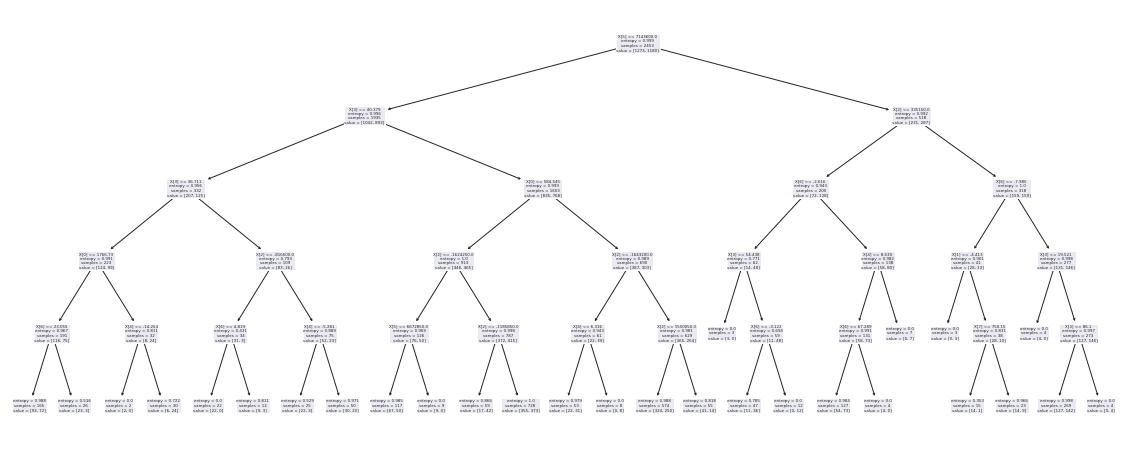

In [27]:
from sklearn import tree
from sklearn.tree import export_text
dtree = clf_dict['DTree']

#print(dtree.feature_importances_)
tree.plot_tree(dtree)

#print(dtree.tree_.feature)



rules = export_text(dtree, feature_names=(list(X_train.columns)))

print(rules)

In [34]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean, std


data_columns = ['Volume', 'Volume_diff', 'PercentageDiff', 'Next']
dataset = df.copy()
dataset = df.loc[:, data_columns]
print(dataset.head())
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']


model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

      Volume  Volume_diff  PercentageDiff    Next
20   7277500      2464000        1.673412  higher
21  26123100     18845600        2.734279   lower
22  25850700      -272400       -3.385018   lower
23   6110900    -19739800       -0.615135  higher
24   8612700      2501800        2.987083  higher
Accuracy: 0.512 (0.031)


In [38]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
selected = sel.fit_transform(X)

print(X.shape)
print(selected.shape)

(3505, 3)
(3505, 3)
